In [1]:
# Custom RNN

# CUSTOM CNN

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import os
import pathlib
import random as rn
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
import tensorflow_hub as hub

from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.callbacks import EarlyStopping

# adding an initialiser

import tensorflow as tf
from tensorflow.keras import layers, models, initializers

# adding a reflective layer
from keras.layers import Layer


# Transfer Learning with InceptionV3

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.models import load_model
from sklearn.metrics import accuracy_score, f1_score
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))


Num GPUs Available:  1


In [3]:
data_dir = "/Users/narendrafuloria/Desktop/Indian_Dataset cleaned 2/"
train_path = "/Users/narendrafuloria/Desktop/Indian_Dataset cleaned 2/Final_Training/Images/"
test_path = "//Users/narendrafuloria/Desktop/Indian_Dataset cleaned 2/Final_Test/Images/"
height = 64
width = 64

In [4]:
classes = { 0:'Give way',
            1:'No entry',
            2:'One-way traffic',
           
            4:'No vehcils in both directions',
            5:'NO ENTRY FOR CYCLES',
            6:'NO ENTRY FOR GOODS VEHCILS',
            7:'NO ENTRY FOR PEDESTRIANS',
            8:'NO ENTRY FOR BULLOCK CARTS',
            9:'NO ENTRY FOR HAND CARTS',
            10:'NO ENTRY FOR MOTOR VEHCILS',
            11:'HEIGHT LIMIT',
            12:'WEIGHT LIMIT',
            13:'AXLE WEIGHT LIMIT',
            14:'LENGTH LIMIT',
            15:'NO LEFT TURN',
            16:'NO RIGHT TURN',
            17:'NO OVERTAKING',
            18:'MAXIMUM SPEED LIMIT 90KM/HR',
            19:'MAXIMUM SPEED LIMIT 110 KM/HR',
            20:'HORN PROHIBITED',
            21:'NO PARKING',
            22:'NO STOPPING',
            23:'TURN LEFT',
            24:'TURN RIGHT',
            25:'STEEP DESCENT',
            26:'STEEP ASCENT',
            27:'NARROW ROAD',
            28: 'NARROW BRIDGE',
            29:'UNPROTECTED QUAY',
            30:'ROAD HUMP',
            31:'DIP',
            32:'LOOSE GRAVEL',
            33:'FALLING ROCKS',
            34:'CATTLE',
            35:'CROSSROADS',
            36:'SIDE ROAD JUNCTION',
            
            38:'OBLIQUE SIDE ROAD JUNCTION',
            40:'T- JUNCTION',
            41:'Y-JUNCTION',
            42:'STAGGERD SIDE ROAD JUNCTION',
            
            44: 'ROUNDABOUT',
            45: 'GUARDED LEVEL CROSSING AHEAD',
            46: 'UNGUARDED LEVEL CROSSING AHEAD',
            47: 'LEVEL CROSSING COUNTDOWN MARKER',

            51: 'PARKING',
            52: 'BUS STOP',
            53: 'FIRST AID POST',
            54: 'TELEPHONE',
            55: 'FILLING STATION',
            56: 'HOTEL',
            57: 'RESTAURANT',
            58: 'REFRESHMENTS'}
            

In [5]:
batch_size = 100
seed = 42

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range = 20, zoom_range = 0.2, vertical_flip =True,
                                   validation_split=0.2)
train_dataset = train_datagen.flow_from_directory(train_path,
                                                  target_size=(height, width),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  seed=seed,
                                                  color_mode='rgb',
                                                  interpolation='hamming',
                                                  subset='training')

test_datagen = ImageDataGenerator(rescale=1./255,rotation_range = 20, zoom_range = 0.2,vertical_flip = True,
                                  validation_split=0.2)
test_dataset = test_datagen.flow_from_directory(train_path, 
                                                target_size=(height, width),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True,
                                                seed=seed,
                                                color_mode='rgb',
                                                interpolation='hamming',
                                                subset='validation')
print(len(train_dataset))

Found 10182 images belonging to 52 classes.
Found 2517 images belonging to 52 classes.
102


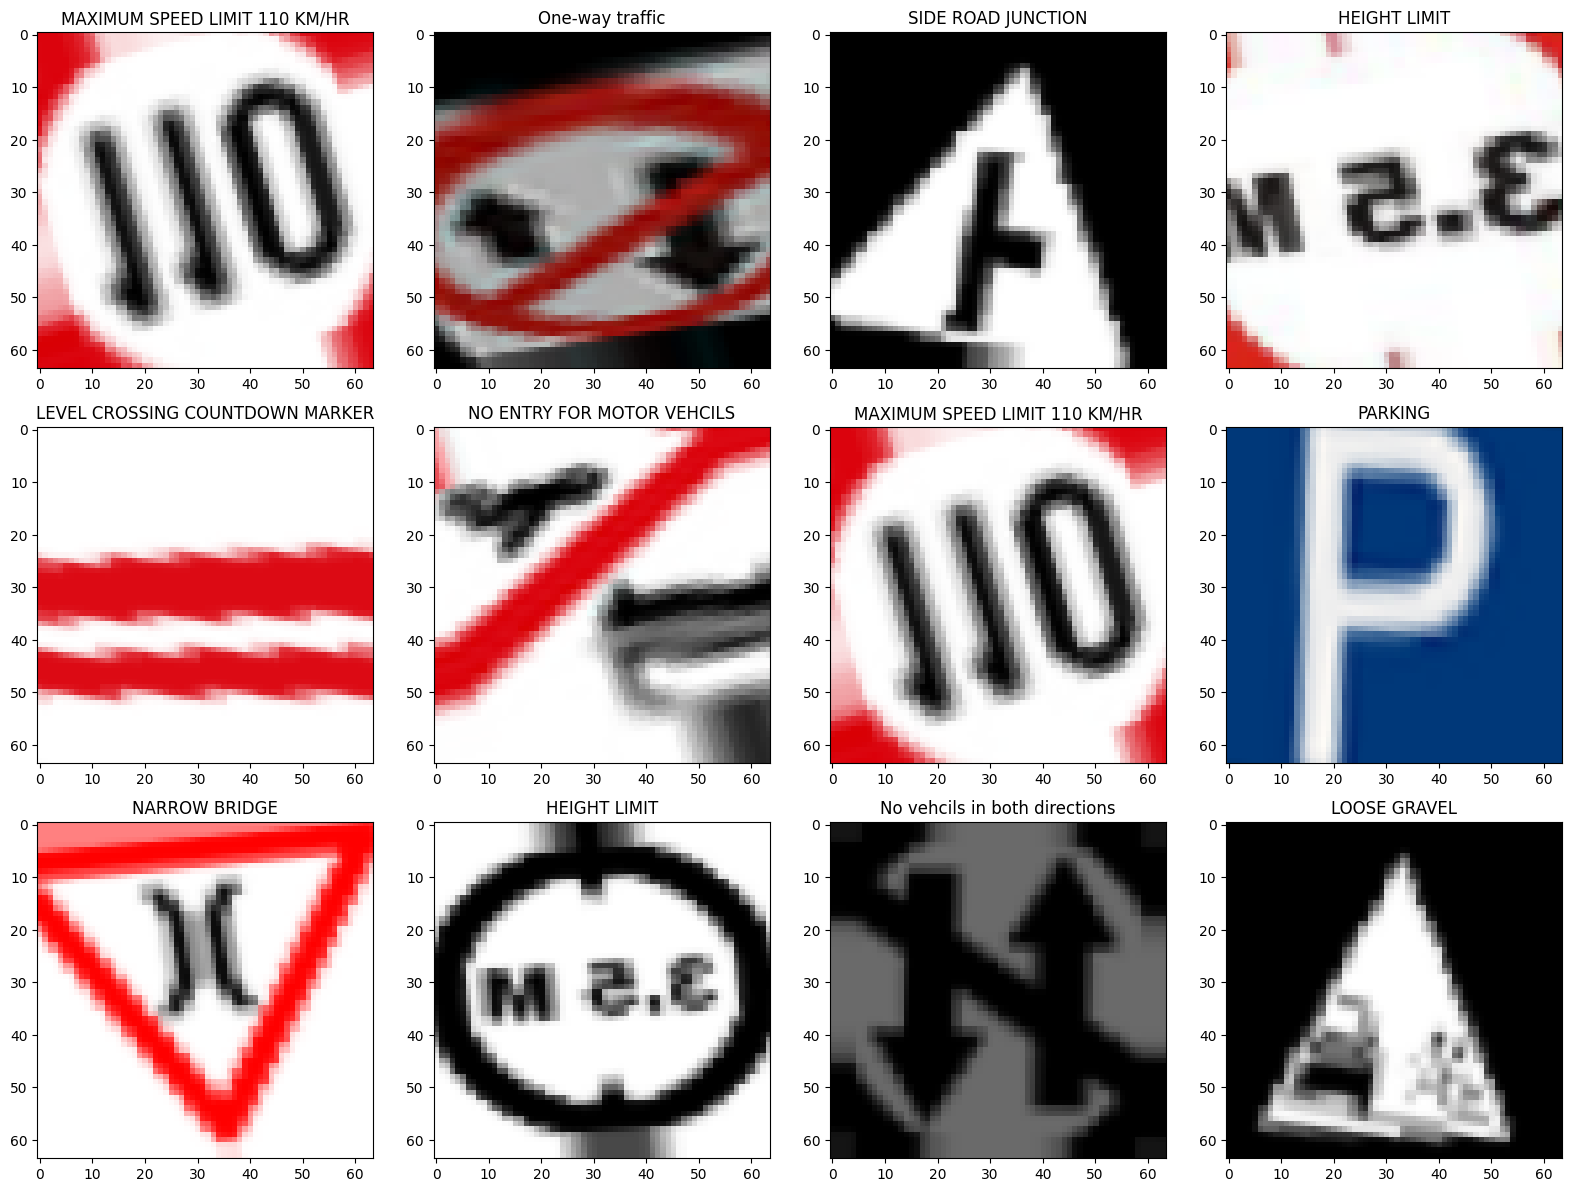

In [7]:
fig,ax=plt.subplots(3,4)
fig.set_size_inches(16,12)
img,y = train_dataset.next()
for i in range(3):
    for j in range (4):
        l=rn.randint(0,batch_size-1)
        label = classes[int(list(train_dataset.class_indices.keys())[np.argmax(y[l])])]
        ax[i,j].imshow(img[l])
        ax[i,j].set_title(label)

plt.tight_layout()

In [8]:
class ReflectivePadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        super(ReflectivePadding2D, self).__init__(**kwargs)
        self.padding = padding

    def call(self, inputs):
        return tf.pad(inputs, [[0, 0], [self.padding[0], self.padding[0]], [self.padding[1], self.padding[1]], [0, 0]], mode='REFLECT')

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 
                input_shape[1] + 2 * self.padding[0], 
                input_shape[2] + 2 * self.padding[1], 
                input_shape[3])


In [9]:
model = keras.models.Sequential([ReflectivePadding2D(padding=(1, 1), input_shape=(height, width, 3)),
    keras.layers.Conv2D(filters= 64 , kernel_size=(5,5), activation='swish', kernel_initializer=initializers.HeNormal()),
    ReflectivePadding2D(padding=(1, 1)),
    keras.layers.Conv2D(filters= 64, kernel_size=(3,3), kernel_initializer=initializers.HeNormal(), activation='swish'),

    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.Dropout(rate=0.5),


    ReflectivePadding2D(padding=(1, 1)),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3),kernel_initializer=initializers.HeNormal(), activation='swish'),

    ReflectivePadding2D(padding=(1, 1)),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), kernel_initializer=initializers.HeNormal(), activation='swish'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.Dropout(rate=0.5),

    ReflectivePadding2D(padding=(1, 1)),
    keras.layers.Conv2D(filters= 256, kernel_size=(3,3), kernel_initializer=initializers.HeNormal(), activation='swish'),
    ReflectivePadding2D(padding=(1, 1)),
    keras.layers.Conv2D(filters= 256, kernel_size=(3,3), kernel_initializer=initializers.HeNormal(), activation='swish'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Dropout(rate=0.5),


    # keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='swish'),
    # keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='swish'),
    # keras.layers.MaxPool2D(pool_size=(2, 2)),
    # keras.layers.BatchNormalization(axis=-1),


    keras.layers.Flatten(),
    # keras.layers.Dense(1024, activation='swish'),
    # keras.layers.BatchNormalization(),
    # keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(512, kernel_initializer=initializers.HeNormal(), activation='swish'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),


    keras.layers.Dense(52, activation='softmax')
])

2024-11-19 11:25:13.808636: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-11-19 11:25:13.808667: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-19 11:25:13.808675: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-19 11:25:13.808705: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-19 11:25:13.808722: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reflective_padding2d (Refl  (None, 66, 66, 3)         0         
 ectivePadding2D)                                                
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 64)        4864      
                                                                 
 reflective_padding2d_1 (Re  (None, 64, 64, 64)        0         
 flectivePadding2D)                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 64)        0         
 D)                                                              
                                                        

In [11]:
alpha= 0.001
epochs=100
optim = keras.optimizers.legacy.Adam(learning_rate=alpha)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.5,          # Factor by which the learning rate will be reduced
    patience=2,         # Number of epochs with no improvement after which learning rate will be reduced
    min_delta=1e-2,      # Minimum change to qualify as an improvement
    cooldown=0,          # Number of epochs to wait before resuming normal operation after lr has been reduced
    min_lr=1e-6          # Lower bound on the learning rate
)
model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Adding early stopping 

early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=5,            # Number of epochs with no improvement before stopping
    verbose=1,             # Verbosity mode
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)





In [12]:

history = model.fit(train_dataset,
                    steps_per_epoch=len(train_dataset),
                    epochs=epochs,
                    validation_data=test_dataset,
                    validation_steps=len(test_dataset), callbacks = (reduce_lr, early_stopping))
                

Epoch 1/100


2024-11-19 11:25:14.894061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


102/102 [==============================] - 68s 649ms/step - loss: 2.6131 - accuracy: 0.3696 - val_loss: 5.6795 - val_accuracy: 0.1605 - lr: 0.0010
Epoch 2/100
102/102 [==============================] - 64s 624ms/step - loss: 1.1646 - accuracy: 0.6596 - val_loss: 2.4643 - val_accuracy: 0.4760 - lr: 0.0010
Epoch 3/100
102/102 [==============================] - 61s 599ms/step - loss: 0.7138 - accuracy: 0.7866 - val_loss: 1.0141 - val_accuracy: 0.7203 - lr: 0.0010
Epoch 4/100
102/102 [==============================] - 60s 588ms/step - loss: 0.5028 - accuracy: 0.8468 - val_loss: 0.5123 - val_accuracy: 0.8530 - lr: 0.0010
Epoch 5/100
102/102 [==============================] - 58s 567ms/step - loss: 0.3849 - accuracy: 0.8803 - val_loss: 0.4999 - val_accuracy: 0.8693 - lr: 0.0010
Epoch 6/100
102/102 [==============================] - 56s 550ms/step - loss: 0.3261 - accuracy: 0.8984 - val_loss: 0.4538 - val_accuracy: 0.8562 - lr: 0.0010
Epoch 7/100
102/102 [==============================] - 56s

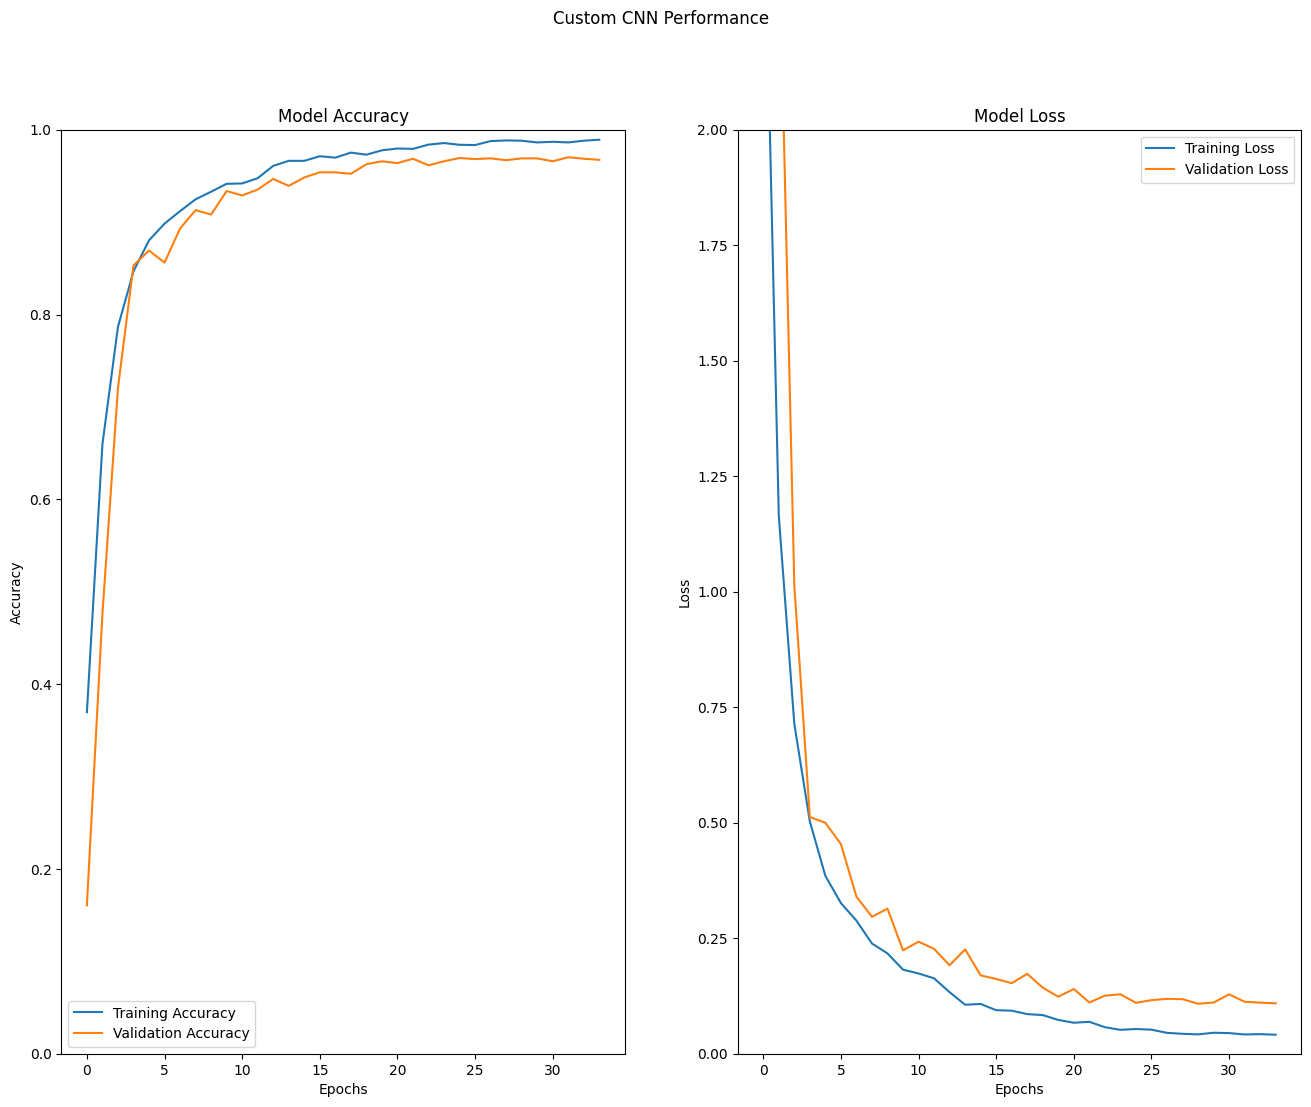

<Figure size 1000x700 with 0 Axes>

In [13]:
fig,ax=plt.subplots(1,2)
fig.set_size_inches(16,12)
performance = pd.DataFrame(history.history)
plt.figure(figsize=(10,7))
ax[1].plot(performance[['loss','val_loss']])
ax[1].legend(['Training Loss', 'Validation Loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_ylim(0,2)
ax[0].plot(performance[['accuracy','val_accuracy']])
ax[0].legend(['Training Accuracy', 'Validation Accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0,1)
fig.suptitle('Custom CNN Performance')
plt.show()

In [14]:
def map_pred(pred):
    return [int(list(train_dataset.class_indices.keys())[i]) for i in pred]
# test_df = pd.read_csv('/Users/narendrafuloria/content/GTSRB/Final_Test/Images/GT-final_test.csv',delimiter=';')

test_labels = np.array([])
imgs = np.array([])
for filename in os.listdir(test_path):
    
    if filename[0:2] != ".D":

        i = np.array(int(filename[0:2]))
        test_labels = np.append(test_labels , i)
        imgs = np.append(imgs,filename)
  

   
# print(imgs)


data =[]

for img in imgs:
    try:
        image = cv2.imread(test_path +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((height, width))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255


In [15]:
pred = model.predict(X_test)

pred = map_pred(pred.argmax(axis=-1))

f1 = f1_score(test_labels, pred, average='weighted')  # Use 'macro' or 'micro' if needed
print(f"f1 SCORE is: {f1}")

#r2 = r2_score(test_labels, pred)  # This assumes test_labels and pred are continuous values

def calculate_r1_score(y_true, y_pred):
    """
    Calculate the R1 score (Recall at Rank 1).
    
    Parameters:
    y_true (list): True labels for the data.
    y_pred (list): Predicted labels for the data.
    
    Returns:
    float: R1 score.
    """
    # Ensure y_true and y_pred are numpy arrays for easier manipulation
    # y_true = np.array(y_true)
    # y_pred = np.array(y_pred)
    
    # Initialize a counter for true positives at rank 1
    true_positives = 0
    
    # Iterate through each prediction
    for true_label, predicted_label in zip(y_true, y_pred):
        if true_label == predicted_label:
            true_positives += 1
    
    # Calculate R1 score
    r1_score = true_positives / len(y_true)
    
    return r1_score







print('Test Data accuracy: ',accuracy_score(test_labels, pred)*100)

calculate_r1_score(test_labels, pred)


26/26 [==============================] - 1s 38ms/step
f1 SCORE is: 0.8929979405653341
Test Data accuracy:  89.4607843137255


0.8946078431372549

4/4 [==============================] - 0s 72ms/step


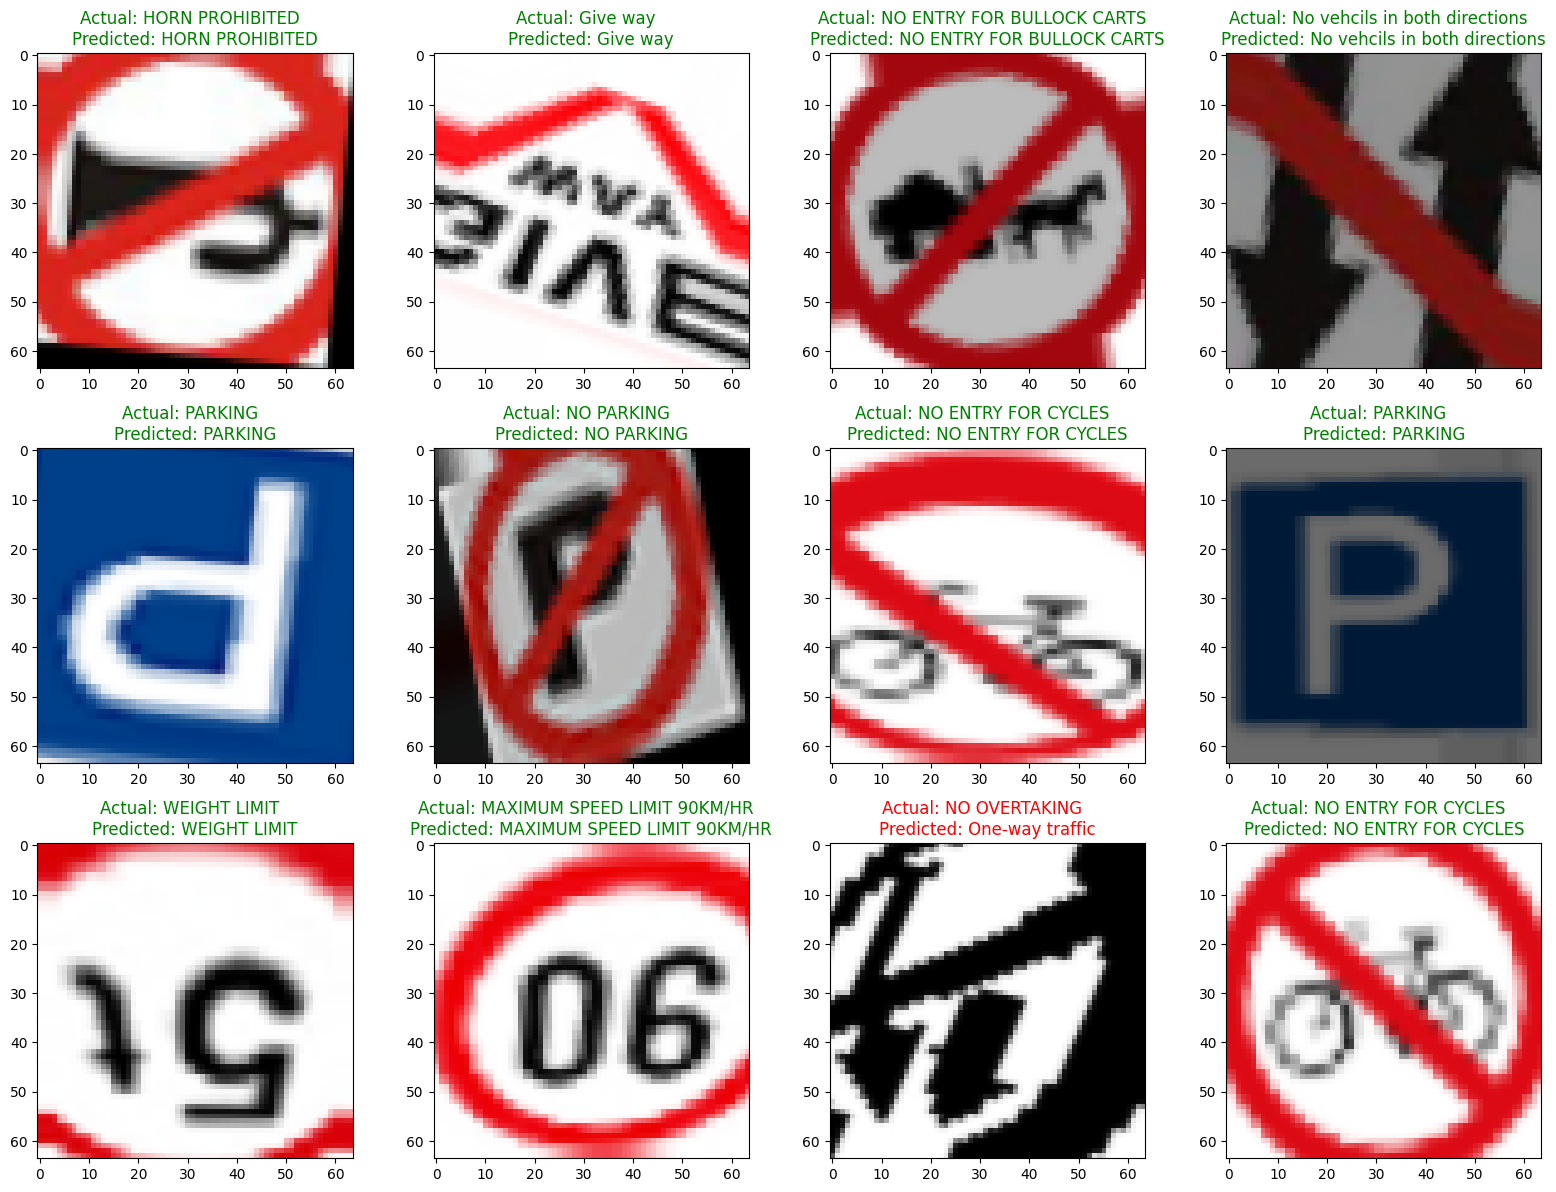

In [16]:
fig,ax=plt.subplots(3,4)
fig.set_size_inches(16,12)
val_images, val_labels = test_dataset.next()
predicted = model.predict(val_images)
predicts = map_pred(np.argmax(predicted, axis=-1))
labels = map_pred(np.argmax(val_labels, axis=-1))

for i in range(3):
    for j in range (4):
        idx=rn.randint(0,batch_size-1)
        ax[i,j].imshow(val_images[idx])
        if labels[idx] == predicts[idx]:
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'green')
        else:
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'red')

plt.tight_layout()

# INCEPTION V3- BASED MODEL ARCHITECTURE

In [17]:

# Load InceptionV3 pre-trained on ImageNet
inception_height = 75
inception_width = 75
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(inception_height, inception_width, 3))
base_model.trainable = False

In [18]:
incept_model = tf.keras.Sequential([base_model,
                                   keras.layers.GlobalAveragePooling2D(),
                                   keras.layers.Dropout(0.5),
                                   keras.layers.Dense(256, activation='relu'),
                                   keras.layers.BatchNormalization(),
                                   keras.layers.Dropout(rate=0.3),
                                   keras.layers.Dense(52, activation='softmax')
                                ])
incept_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 batch_normalization_98 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dropout_5 (Dropout)         (None, 256)              

In [19]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)
train_dataset = train_datagen.flow_from_directory(train_path,
                                                  target_size=(inception_height, inception_width),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  seed=seed,
                                                  color_mode='rgb',
                                                  interpolation='hamming',
                                                  subset='training')

test_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split=0.2)
test_dataset = test_datagen.flow_from_directory(train_path,
                                                target_size=(inception_height, inception_width),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True,
                                                seed=seed,
                                                color_mode='rgb',
                                                interpolation='hamming',
                                                subset='validation')
print(len(train_dataset))

Found 10182 images belonging to 52 classes.
Found 2517 images belonging to 52 classes.
102


In [20]:
alpha=0.0001
epochs=15
optim = keras.optimizers.legacy.Adam(learning_rate=alpha)
incept_model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [21]:
incept_history = incept_model.fit(train_dataset,
                            steps_per_epoch=len(train_dataset),
                            epochs=epochs,
                            validation_data=test_dataset,
                            validation_steps=len(test_dataset))

Epoch 1/15
102/102 [==============================] - 21s 185ms/step - loss: 4.0606 - accuracy: 0.1071 - val_loss: 2.7822 - val_accuracy: 0.3258
Epoch 2/15
102/102 [==============================] - 18s 173ms/step - loss: 2.8820 - accuracy: 0.2926 - val_loss: 2.1764 - val_accuracy: 0.4736
Epoch 3/15
102/102 [==============================] - 18s 175ms/step - loss: 2.3687 - accuracy: 0.3953 - val_loss: 1.8837 - val_accuracy: 0.5356
Epoch 4/15
102/102 [==============================] - 17s 164ms/step - loss: 2.0273 - accuracy: 0.4619 - val_loss: 1.6917 - val_accuracy: 0.5741
Epoch 5/15
102/102 [==============================] - 17s 166ms/step - loss: 1.8349 - accuracy: 0.5125 - val_loss: 1.5544 - val_accuracy: 0.6015
Epoch 6/15
102/102 [==============================] - 17s 168ms/step - loss: 1.6573 - accuracy: 0.5522 - val_loss: 1.4458 - val_accuracy: 0.6273
Epoch 7/15
102/102 [==============================] - 17s 170ms/step - loss: 1.5346 - accuracy: 0.5812 - val_loss: 1.3592 - val_ac

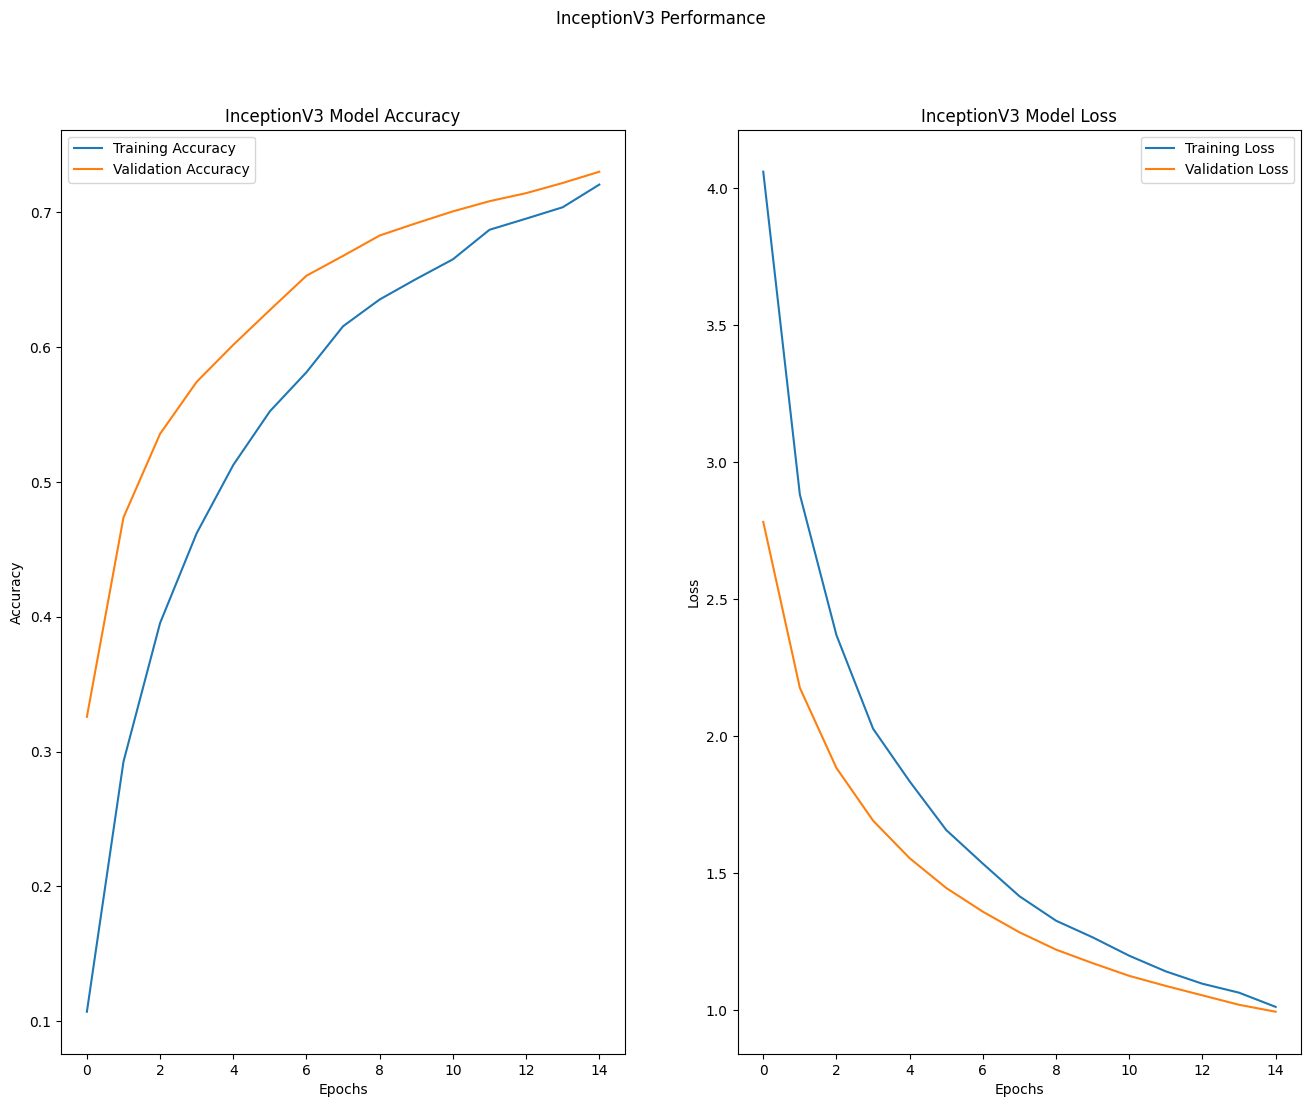

<Figure size 1000x700 with 0 Axes>

In [22]:
fig,ax=plt.subplots(1,2)
fig.set_size_inches(16,12)
performance = pd.DataFrame(incept_history.history)
plt.figure(figsize=(10,7))
ax[1].plot(performance[['loss','val_loss']])
ax[1].legend(['Training Loss', 'Validation Loss'])
ax[1].set_title('InceptionV3 Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
# ax[1].set_ylim(0,1)
ax[0].plot(performance[['accuracy','val_accuracy']])
ax[0].legend(['Training Accuracy', 'Validation Accuracy'])
ax[0].set_title('InceptionV3 Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
# ax[0].set_ylim(0.5,1)
fig.suptitle('InceptionV3 Performance')
plt.show()

# Mapping Predictions for InceptionV3 Model


In [24]:
def map_pred_inception(pred):
    return [int(list(train_dataset.class_indices.keys())[i]) for i in pred]

    
test_labels = np.array([])
imgs = np.array([])
    
for filename in os.listdir(test_path):
    
    if filename[0:2] != ".D":

        i = np.array(int(filename[0:2]))
        test_labels = np.append(test_labels , i)
        imgs = np.append(imgs,filename)

data_inception = []
for img in imgs:
    try:
        image = cv2.imread(test_path +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((inception_height, inception_width))
        data_inception.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test_incept = np.array(data_inception)
X_test_incept = X_test_incept/255

# Evaluating InceptionV3-Based Model on Test Data


In [25]:
from sklearn.metrics import accuracy_score
pred_incept = incept_model.predict(X_test_incept)
pred_incept = map_pred_inception(pred_incept.argmax(axis=-1))
print('Test Data accuracy: ',accuracy_score(test_labels, pred_incept)*100)

26/26 [==============================] - 4s 84ms/step
Test Data accuracy:  54.779411764705884


# MobileNetV2 as Base Model


In [26]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (height, width, 3), include_top = False, weights = "imagenet")
base_model.trainable = False

## MobileNetV2-Based Model Architecture


In [27]:
mob_model = tf.keras.Sequential([base_model,
                                   keras.layers.GlobalAveragePooling2D(),
                                   keras.layers.Dropout(0.2),
                                   keras.layers.Dense(512, activation='relu'),
                                   keras.layers.BatchNormalization(),
                                   keras.layers.Dropout(rate=0.2),
                                   keras.layers.Dense(52, activation='softmax')
                                ])
mob_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 2, 2, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_6 (Dropout)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               655872    
                                                                 
 batch_normalization_99 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                      

## Model Compilation for MobileNetV2-Based Model


In [28]:
alpha=0.01
epochs=8
optim = keras.optimizers.legacy.Adam(learning_rate=alpha)
mob_model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])

## Training MobileNetV2-Based Model


In [29]:

mob_history = mob_model.fit(train_dataset,
                          steps_per_epoch=len(train_dataset),
                          epochs=epochs,
                          validation_data=test_dataset,
                          validation_steps=len(test_dataset))

Epoch 1/8
102/102 [==============================] - 12s 97ms/step - loss: 1.5286 - accuracy: 0.6099 - val_loss: 1.3089 - val_accuracy: 0.6845
Epoch 2/8
102/102 [==============================] - 7s 72ms/step - loss: 0.7839 - accuracy: 0.7675 - val_loss: 0.8619 - val_accuracy: 0.7612
Epoch 3/8
102/102 [==============================] - 7s 73ms/step - loss: 0.6121 - accuracy: 0.8129 - val_loss: 0.7464 - val_accuracy: 0.7942
Epoch 4/8
102/102 [==============================] - 8s 74ms/step - loss: 0.4919 - accuracy: 0.8423 - val_loss: 0.7467 - val_accuracy: 0.7914
Epoch 5/8
102/102 [==============================] - 7s 73ms/step - loss: 0.4647 - accuracy: 0.8535 - val_loss: 0.7243 - val_accuracy: 0.8017
Epoch 6/8
102/102 [==============================] - 8s 73ms/step - loss: 0.4249 - accuracy: 0.8691 - val_loss: 0.7317 - val_accuracy: 0.8057
Epoch 7/8
102/102 [==============================] - 8s 75ms/step - loss: 0.3814 - accuracy: 0.8736 - val_loss: 0.7513 - val_accuracy: 0.8002
Epoch

## MobileNetV2-Based Model Performance Visualization


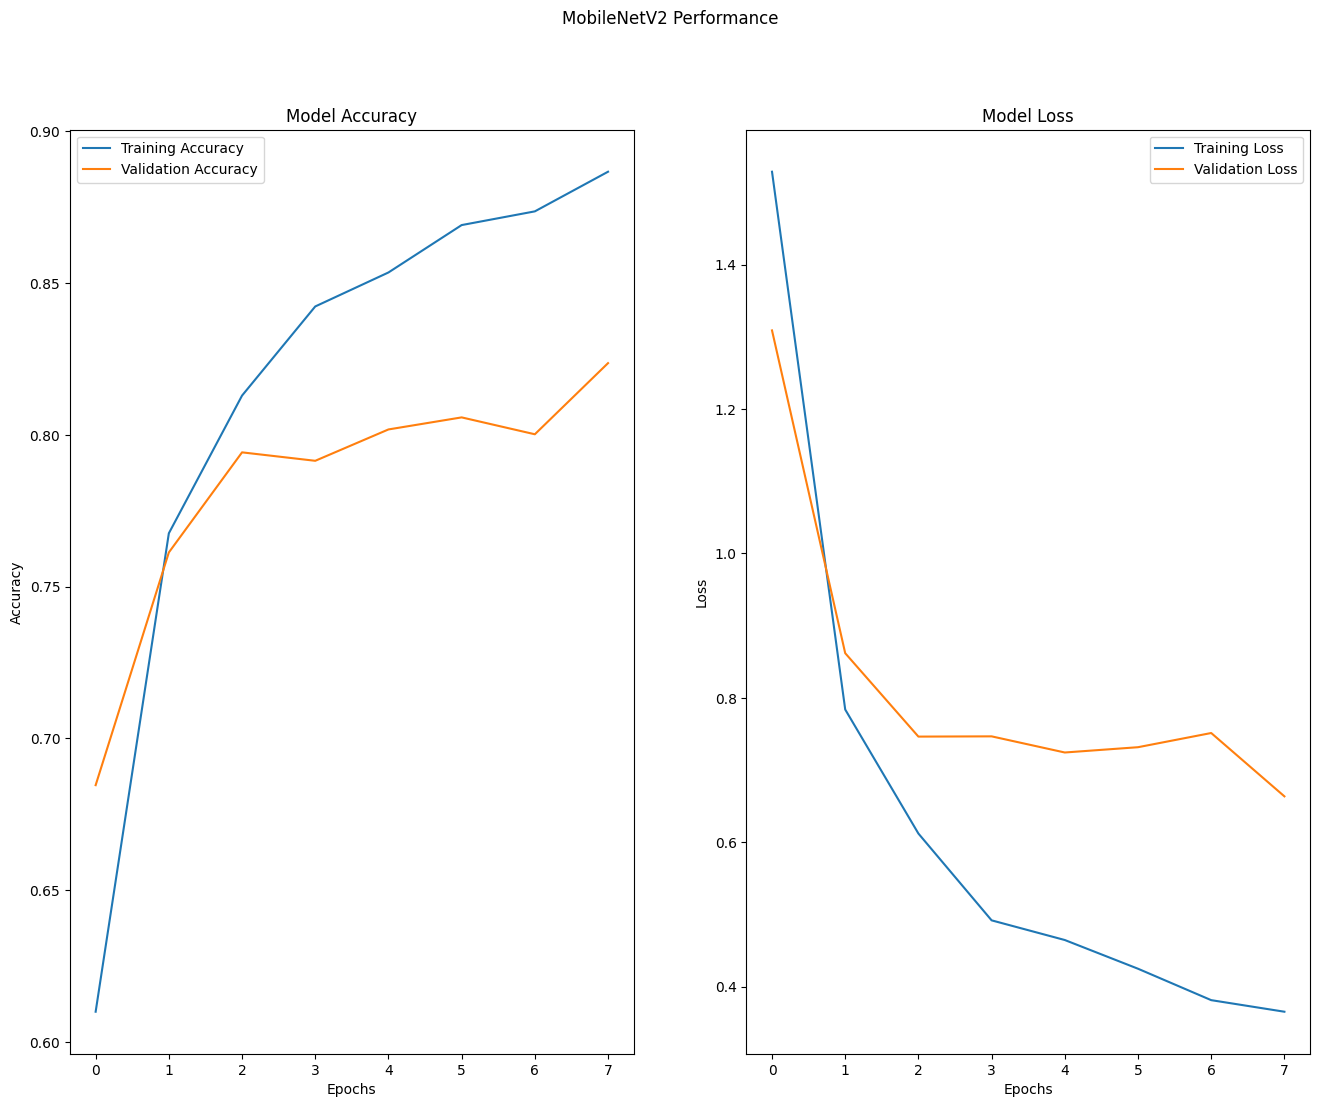

<Figure size 1000x700 with 0 Axes>

In [30]:
fig,ax=plt.subplots(1,2)
fig.set_size_inches(16,12)
performance = pd.DataFrame(mob_history.history)
plt.figure(figsize=(10,7))
ax[1].plot(performance[['loss','val_loss']])
ax[1].legend(['Training Loss', 'Validation Loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
# ax[1].set_ylim(0,1)
ax[0].plot(performance[['accuracy','val_accuracy']])
ax[0].legend(['Training Accuracy', 'Validation Accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
# ax[0].set_ylim(0.5,1)
fig.suptitle('MobileNetV2 Performance')
plt.show()

## MobileNetV2-Based Model Evaluation on Test Data


In [31]:
from sklearn.metrics import accuracy_score
pred = mob_model.predict(X_test)
pred = map_pred(pred.argmax(axis=-1))
print('Test Data accuracy: ',accuracy_score(test_labels, pred)*100)

26/26 [==============================] - 3s 53ms/step
Test Data accuracy:  37.99019607843137


# VGG19-Based Model Architecture


In [32]:
vgg_model = tf.keras.Sequential([VGG19(weights='imagenet', include_top=False, input_shape=(height,width,3)),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Flatten(),
                                 keras.layers.Dense(512, activation='sigmoid'),
                                 keras.layers.Dense(52, activation='softmax')
                                ])

vgg_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 batch_normalization_100 (B  (None, 2, 2, 512)         2048      
 atchNormalization)                                              
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 dense_7 (Dense)             (None, 52)                26676     
                                                                 
Total params: 21102196 (80.50 MB)
Trainable params: 21101172 (80.49 MB)
Non-trainable params: 1024 (4.00 KB)
___________

In [33]:
alpha=0.0001
epochs=8
optim = keras.optimizers.legacy.Adam(learning_rate=alpha)
vgg_model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])

## Model Compilation for VGG19-Based Model


In [34]:
alpha=0.0001
epochs=8
optim = keras.optimizers.legacy.Adam(learning_rate=alpha)
vgg_model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])

## Training VGG19-Based Model


In [35]:
print(train_dataset)
vgg_history = vgg_model.fit(train_dataset,
                        steps_per_epoch=len(train_dataset),
                        epochs=epochs,
                        validation_data=test_dataset,
                        validation_steps=len(test_dataset))

Epoch 1/8
102/102 [==============================] - 107s 1s/step - loss: 1.0516 - accuracy: 0.7916 - val_loss: 0.8018 - val_accuracy: 0.9476
Epoch 2/8
102/102 [==============================] - 113s 1s/step - loss: 0.1004 - accuracy: 0.9846 - val_loss: 0.3447 - val_accuracy: 0.9766
Epoch 3/8
102/102 [==============================] - 120s 1s/step - loss: 0.0432 - accuracy: 0.9933 - val_loss: 0.1423 - val_accuracy: 0.9758
Epoch 4/8
102/102 [==============================] - 127s 1s/step - loss: 0.0298 - accuracy: 0.9947 - val_loss: 0.0856 - val_accuracy: 0.9793
Epoch 5/8
102/102 [==============================] - 134s 1s/step - loss: 0.0231 - accuracy: 0.9965 - val_loss: 0.0675 - val_accuracy: 0.9877
Epoch 6/8
102/102 [==============================] - 127s 1s/step - loss: 0.0162 - accuracy: 0.9977 - val_loss: 0.0498 - val_accuracy: 0.9905
Epoch 7/8
102/102 [==============================] - 129s 1s/step - loss: 0.0082 - accuracy: 0.9988 - val_loss: 0.0530 - val_accuracy: 0.9885
Epoch 

## VGG19-Based Model Performance Visualization


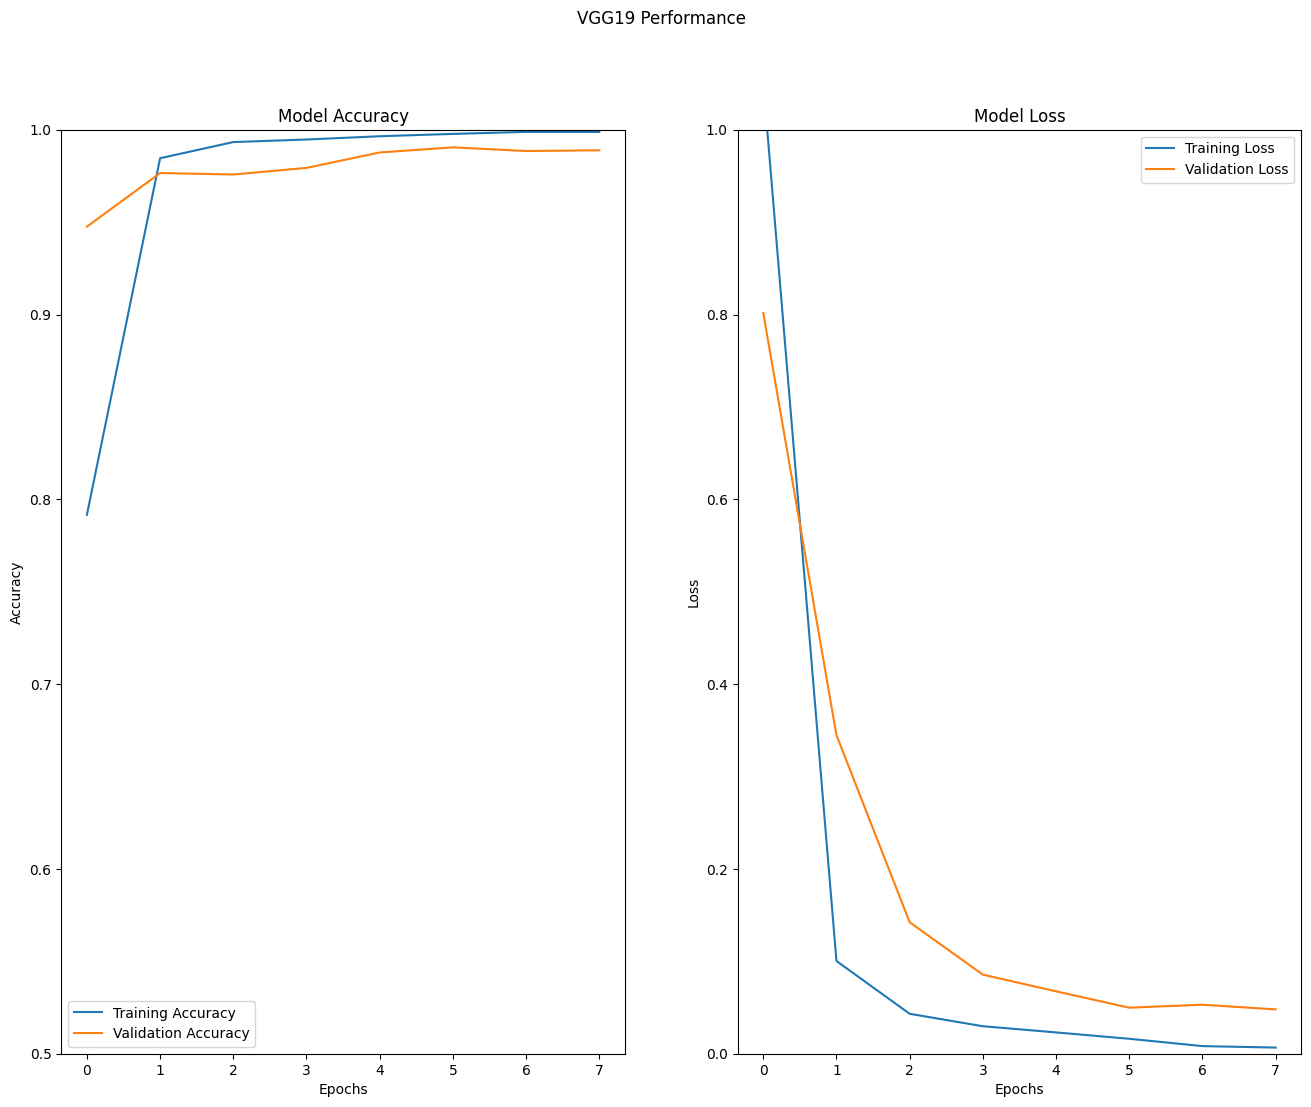

<Figure size 1000x700 with 0 Axes>

In [36]:
fig,ax=plt.subplots(1,2)
fig.set_size_inches(16,12)
performance = pd.DataFrame(vgg_history.history)
plt.figure(figsize=(10,7))
ax[1].plot(performance[['loss','val_loss']])
ax[1].legend(['Training Loss', 'Validation Loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_ylim(0,1)
ax[0].plot(performance[['accuracy','val_accuracy']])
ax[0].legend(['Training Accuracy', 'Validation Accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0.5,1)
fig.suptitle('VGG19 Performance')
plt.show()

## VGG19-Based Model Evaluation on Test Data


In [37]:

from sklearn.metrics import accuracy_score
pred = vgg_model.predict(X_test)
pred = map_pred(pred.argmax(axis=-1))
print('Test Data accuracy: ',accuracy_score(test_labels, pred)*100)

26/26 [==============================] - 2s 65ms/step
Test Data accuracy:  95.95588235294117


## Visualizing VGG19 Model Predictions on Validation Data

4/4 [==============================] - 1s 156ms/step


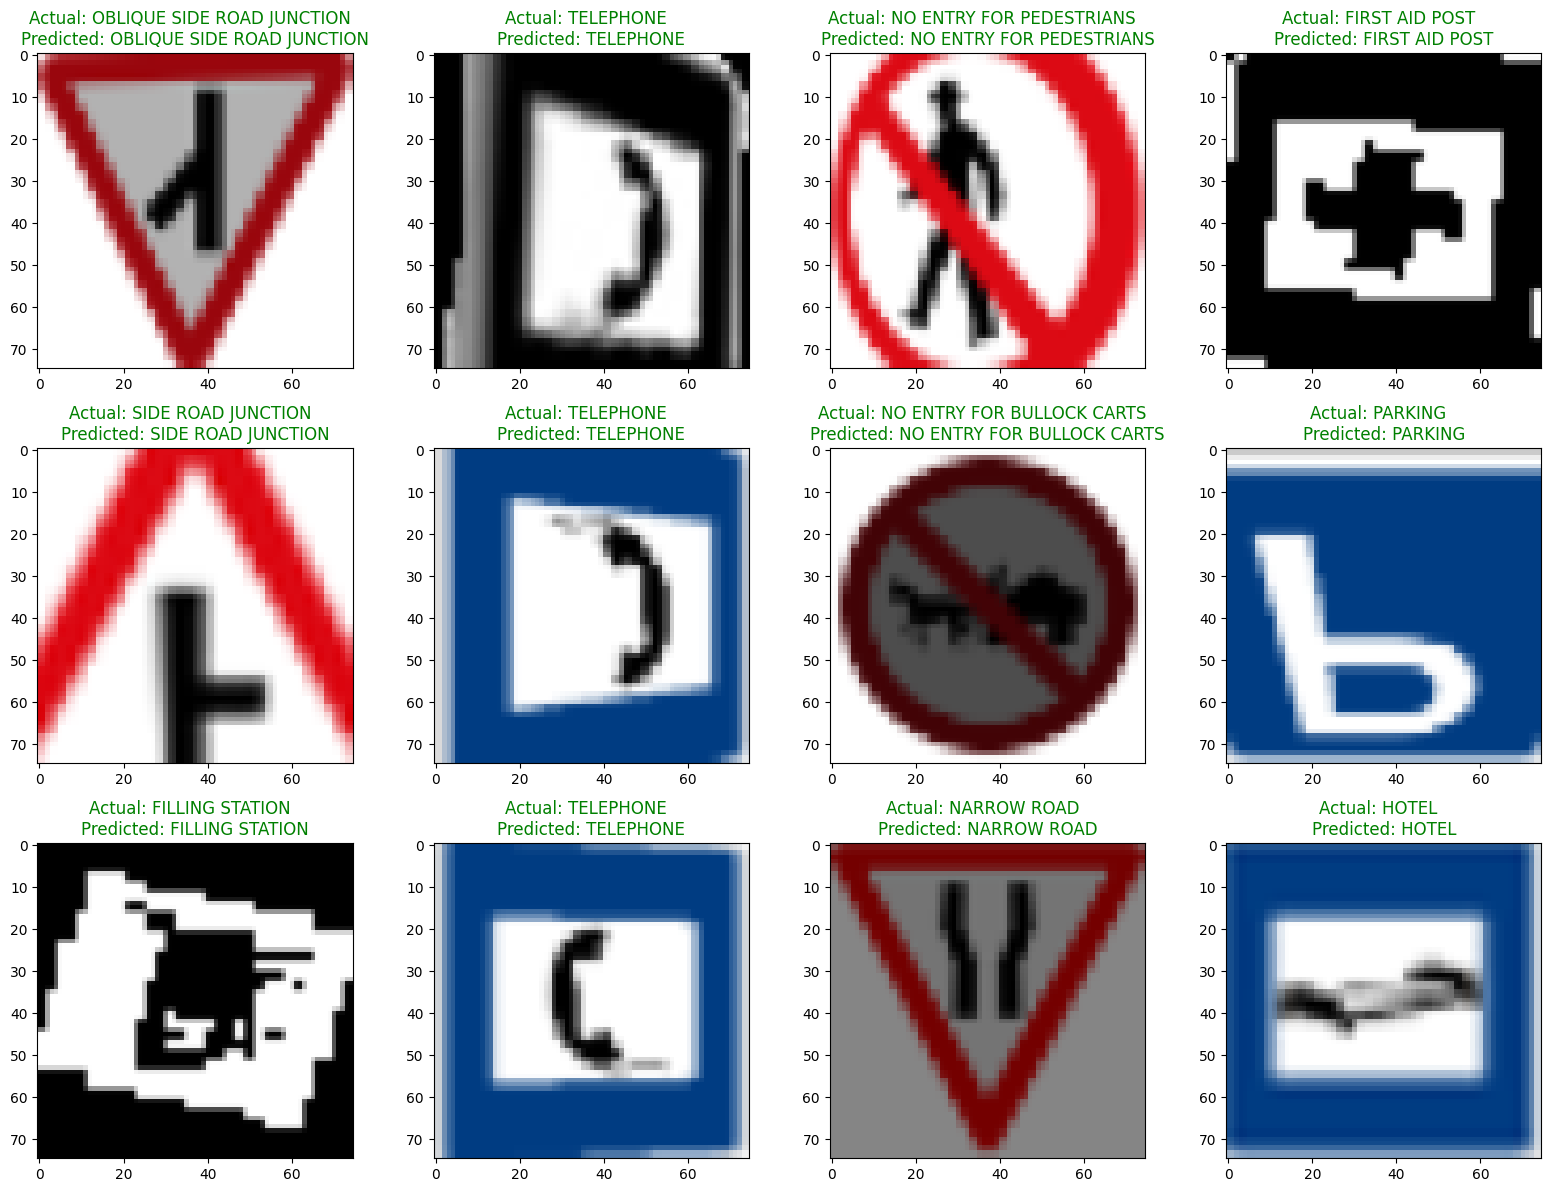

In [38]:
fig,ax=plt.subplots(3,4)
fig.set_size_inches(16,12)
val_images, val_labels = test_dataset.next()
predicted = vgg_model.predict(val_images)
predicts = map_pred(np.argmax(predicted, axis=-1))
labels = map_pred(np.argmax(val_labels, axis=-1))
for i in range(3):
    for j in range (4):
        idx=rn.randint(0,batch_size-1)
        ax[i,j].imshow(val_images[idx])
        if labels[idx] == predicts[idx]:
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'green')
        else:
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'red')

plt.tight_layout()